# Next level development of new infrastructure based on TDI filter
In the new structure, PCI and TDI filters share a common infrastructure.  We develop that infrastrucutre here using the TDI kernels, as TDI is well understood, and can be compared with a well-established result.

Key common elements for development and testing are the common infrastructure for estimating sensitivities and for interpolating results from time-local kernels for application across a wider temporal stretch of data.


In [1]:
from pytdi.michelson import X1, Y1, Z1, X2, Y2, Z2
from pytdi import Data
import h5py
import numpy as np
import copy
import pcipy
from pcipy.data import TimeData
from pcipy.tdi_filter import DeducedTDIFilter as TDIFilter

## Read in data sets

In [2]:
if 0:
    datadir = "/data/jgbaker/software/pylisa/data/"
    orbits = datadir+"keplerian-orbits.h5"
    workdir = datadir+"/simulations/"
    noise_file_base = "2025-07-01_19h38_laser_tm_oms_"
    gw_file_base = "2025-07-01_19h34_"
if 1:
    datadir = "/data/jgbaker/software/pcipy/data"
    workdir = datadir+"/simulations/"
    if 1:
        orbits = workdir+"keplerian-orbits.h5"
        noise_file_base = "2025-04-07_keplerian_locking_N1-12_laser_tm_oms_"
        gw_file_base = "2025-04-07_keplerian_"
    else:
        orbits = workdir+"equalarm-orbits.h5"
        noise_file_base = "2025-04-07_equalarm_locking_N1-12_laser_tm_oms_"
        gw_file_base = "2025-04-07_equalarm_"

skip=1000
mosas_order = ['12', '23', '31', '13', '21', '32']

#### Basic single-link noise data

In [3]:
noise_sim_path = workdir+noise_file_base+"measurements_4Hz.h5"

#get the central frequency
sim = h5py.File(noise_sim_path, 'r')
central_freq = sim.attrs['central_freq']
sim.close()

data_noise = Data.from_instrument(noise_sim_path)
fs = data_noise.fs

#we have to divide by central_freq because the instument sumlation channels are in beat-rate units
y_list = [data_noise.measurements[f'isi_{link}']/central_freq for link in mosas_order]

y_n = TimeData(np.array(y_list, dtype=np.float64)[:,skip:],dt=1/fs,t0=skip/fs,names=mosas_order)

You are using a measurement file in a version that might not be fully supported


#### Matching GW simulations results for the empirical sensitivity calculation

In [4]:
gw_path = workdir+gw_file_base+"gw_measurements_4Hz.h5"

data_gw = Data.from_gws(gw_path,orbits)

#note: the GW mesaurement data are already fractional frequency so we don't divide by central_freq
y_list = [data_gw.measurements[f'isi_{link}'] for link in mosas_order]

y_gw = TimeData(np.array(y_list, dtype=np.float64)[:,skip:],dt=1/fs,t0=skip/fs,names=mosas_order)

You are using a GW file in a development version
You are using a GW file in a version that might not be fully supported
You are using an orbit file in a version that might not be fully supported


In [5]:
##This is the code for computing TDI as we do it in noise_simulation:
if 0:  #the code is just to look at
    data_noise = Data.from_instrument(instr)
    if args.tdi == '2':
        X, Y, Z = X2, Y2, Z2
    else:
        X, Y, Z = X1, Y1, Z1
    # Build other 2.0 Michelson variables
    X_data = X.build(**data_noise.args)
    Y_data = Y.build(**data_noise.args)
    Z_data = Z.build(**data_noise.args)
    # Apply TDI 2.0
    x_noise = X_data(data_noise.measurements)
    y_noise = Y_data(data_noise.measurements)
    z_noise = Z_data(data_noise.measurements)

#### For comparison, we also need the TDI data

In [6]:
#noise
tdipath2 = workdir +  noise_file_base + 'noise_tdi2_4Hz.h5'

tdi2 = h5py.File(tdipath2, 'r')
x2_noise = tdi2['x'][()] / central_freq
y2_noise = tdi2['y'][()] / central_freq
z2_noise = tdi2['z'][()] / central_freq
tdi2.close()

XYZ_file_noise = TimeData(np.array([x2_noise,y2_noise,z2_noise], dtype=np.float64)[:,skip:],dt=1/fs,t0=skip/fs,names='XYZ')

#GW
tdi2_gw_file = workdir+gw_file_base+"gw_tdi2_4Hz.h5"

hdf5 = h5py.File(tdi2_gw_file, 'r')
x2_gw = hdf5['x'][()] #/ central_freq  (gw simulation already in fractional freq)
y2_gw = hdf5['y'][()] #/ central_freq
z2_gw = hdf5['z'][()] #/ central_freq
hdf5.close()

XYZ_file_gw = TimeData(np.array([x2_gw,y2_gw,z2_gw], dtype=np.float64)[:,skip:],dt=1/fs,t0=skip/fs,names='XYZ')


#### Define data range for this study and set up fourier transforms

In [7]:
range_in_hours = 48
ibuff=250   #edge buffer for kernels 

ns = int(range_in_hours * 3600 * fs) # less for dev

In [8]:
#new infrastructure
def get_range(td,istart,iend):
    #extract a subset of a TD (to be added to TD)
    print(td.data.shape)
    newdata = td.data[:,istart:iend]
    #print('-->',newdata.shape)
    newt0=None
    newdt=None
    newnames=None
    if td.t0 is not None:
        newt0 = td.t0 + td.dt*istart
    if td.dt is not None:
        newdt = td.dt
    if td.names is not None:
        newnames=td.names
    #print('old t0,dt:',td.t0,td.dt,'new t0,dt:',newt0,newdt)
    return TimeData(newdata,t0=newt0,dt=newdt,names=newnames)

def get_index_at_time(td,time):
    return (time-td.t0)/td.dt

def get_times(td):
    print('t0,dt:',td.t0,td.dt)
    return np.arange(td.n_samples())*td.dt+td.t0

In [9]:

ytest_n = get_range(y_n,0,ns+2*ibuff)
ytest_gw = get_range(y_gw,0,ns+2*ibuff)

TDItest_n = get_range(XYZ_file_noise,0,ns+2*ibuff)
TDItest_gw = get_range(XYZ_file_gw,0,ns+2*ibuff)

(6, 1035800)
(6, 1035800)
(3, 1035800)
(3, 1035800)


              total        used        free      shared  buff/cache   available
Mem:       15911324     1451636    12184320        1280     2275368    14143768
Swap:             0           0           0


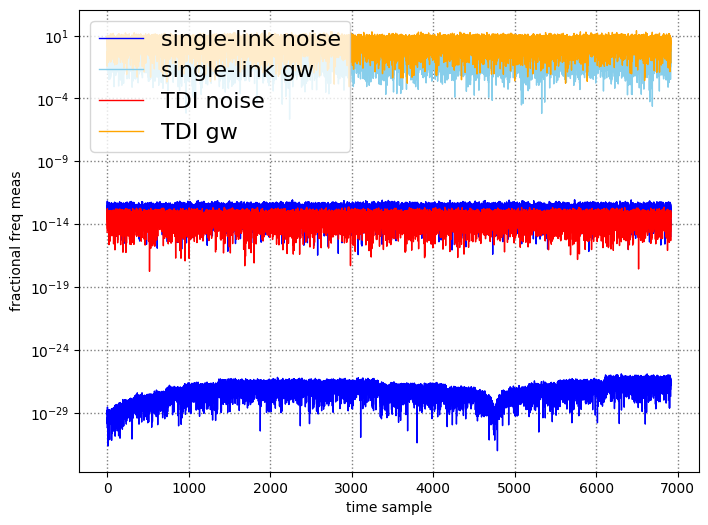

In [10]:
# View data in time domain

import matplotlib.pyplot as plt

_, axes = plt.subplots(1, 1, figsize=(8, 6))
colors = ['blue', 'skyblue', 'red', 'orange', 'purple', 'gray']
# TDI 2.0 

iev = 100
axes.semilogy(np.abs(ytest_n.data[0,::iev]), linewidth=1, color=colors[0], label='single-link noise')
for i in range(1,6):
    axes.semilogy(np.abs(ytest_n.data[i,::iev]), linewidth=1, color=colors[0])
    
axes.semilogy(np.abs(ytest_gw.data[0,::iev]), linewidth=1, color=colors[1], label='single-link gw')
for i in range(1,6):
    axes.semilogy(np.abs(ytest_gw.data[i,::iev]), linewidth=1, color=colors[1])
    
axes.semilogy(np.abs(TDItest_n.data[0,::iev]), linewidth=1, color=colors[2], label='TDI noise')
for i in range(1,3):
    axes.semilogy(np.abs(TDItest_n.data[i,::iev]), linewidth=1, color=colors[2])

axes.semilogy(np.abs(TDItest_gw.data[0,::iev]), linewidth=1, color=colors[3], label='TDI gw')
for i in range(1,3):
    axes.semilogy(np.abs(TDItest_gw.data[i,::iev]), linewidth=1, color=colors[3])
    
    
axes.set_xlabel("time sample")
axes.set_ylabel(r"fractional freq meas")
plt.legend(loc='upper left', fontsize=16)
# axes.set_ylim([1e-24, 1e-17])
#axes.set_xlim([1e-4, 3e-1])
#plt.title("PCI 2.0 (" + str(int(ns/fs/3600))+" hours, nh = "+str(nhalf)+")")
plt.grid(linewidth=1.0, 
         color='gray', 
         linestyle='dotted', 
         which='both', 
         axis='both')
#plt.show()
!free

In [11]:
#Fourier Transform
import pyfftw
from pyfftw.interfaces.numpy_fft import rfft, irfft, fft
pyfftw.interfaces.cache.enable()
# Transform PCI variables to Fourier domain

wd = np.blackman(ns)

## Transform simulated TDI variables to Fourier domain
k2 = np.sum(wd**2)

def do_ft(dataset, fs=fs):
    ns=dataset.n_samples()
    wd=np.blackman(ns)
    f = np.fft.rfftfreq(ns) * fs
    sel=f>0
    print(sel)
    dataset_fft=[rfft(wd * dataset.data[i] ) * np.sqrt(2/(fs*k2)) for i in range(dataset.n_channels())]
    
    return f[sel], np.array(dataset_fft)[:,sel]

[False  True  True ...  True  True  True]
[5.78285384e-06 1.15657077e-05 1.73485615e-05 ... 1.99998843e+00
 1.99999422e+00 2.00000000e+00]
[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]
              total        used        free      shared  buff/cache   available
Mem:       15911324     1651140    11975488        1280     2284696    13944144
Swap:             0           0           0


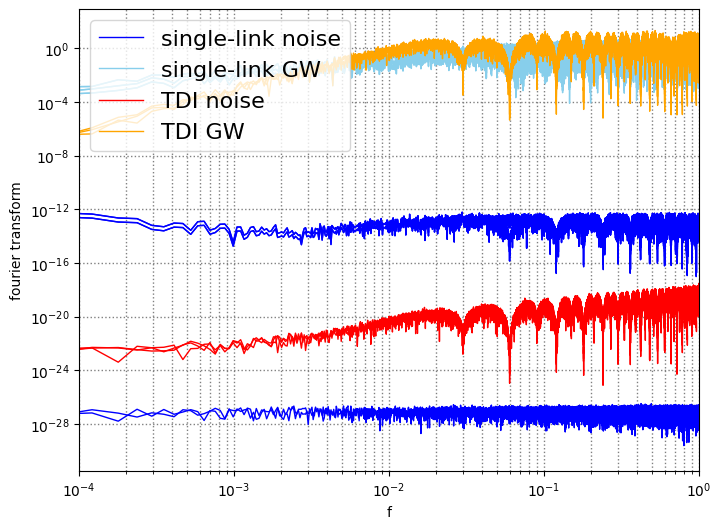

In [12]:
# View data in freq domain

import matplotlib.pyplot as plt
# Comparison with TDI variables
_, axes = plt.subplots(1, 1, figsize=(8, 6))
colors = ['blue', 'skyblue', 'red', 'orange', 'purple', 'gray']
# TDI 2.0 

iev = 10
i0=iev

f,data=do_ft(ytest_n)
axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, color=colors[0], label='single-link noise')
for i in range(1,6):
    axes.loglog(f[i0::iev], np.abs(data[i,i0::iev]), linewidth=1, color=colors[0])
    
print(f)    
f,data=do_ft(ytest_gw)
axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, color=colors[1], label='single-link GW')
for i in range(1,6):
    axes.loglog(f[i0::iev], np.abs(data[i,i0::iev]), linewidth=1, color=colors[1])
    
f,data=do_ft(TDItest_n)
axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, color=colors[2], label='TDI noise')
for i in range(1,3):
    axes.loglog(f[i0::iev], np.abs(data[i,i0::iev]), linewidth=1, color=colors[2])
        
f,data=do_ft(TDItest_gw)
axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, color=colors[3], label='TDI GW')
for i in range(1,3):
    axes.loglog(f[i0::iev], np.abs(data[i,i0::iev]), linewidth=1, color=colors[3])
    
    
axes.set_xlabel("f")
axes.set_ylabel(r"fourier transform")
plt.legend(loc='upper left', fontsize=16)
# axes.set_ylim([1e-24, 1e-17])
axes.set_xlim([1e-4, 1])
#plt.title("PCI 2.0 (" + str(int(ns/fs/3600))+" hours, nh = "+str(nhalf)+")")
plt.grid(linewidth=1.0, 
         color='gray', 
         linestyle='dotted', 
         which='both', 
         axis='both')
#plt.show()
!free

## Fixed time TDI filters
We construct TDI filters set for times at points at start, 1/3, 1/2 and 2/3 of the data range 

In [13]:
istep =  ns // 3
i0set = skip+ibuff+np.array([0, istep, ns//2, 2*istep]) #needed in the original time-grid frame
t_eval_set = i0set/fs
nameset=["start","left","center","right"]
display(np.array(i0set))
display(np.array(i0set)/(ns))

array([  1250, 231650, 346850, 462050])

array([0.00180845, 0.33514178, 0.50180845, 0.66847512])

In [14]:
display(y_n.data.shape)

(6, 1035800)

In [15]:
#Construct filters

TDIfiltset = [ TDIFilter(data_noise,eval_time=t,nleft=200,nright=400) for t in t_eval_set ]
t0set = np.array( [ filt.kernel_ref_time for filt in TDIfiltset ] )

display(t_eval_set)
display(t0set)
#TDIfilt=TDIFilter(data_noise,i0=1000)

array([   312.5,  57912.5,  86712.5, 115512.5])

array([   343.75,  57943.75,  86743.75, 115543.75])

In [16]:
for filt in TDIfiltset:
    display(filt.__dict__)

{'in_chans': ['isi'],
 'mosas_order': ['12', '23', '31', '13', '21', '32'],
 'in_names': ['isi_12', 'isi_23', 'isi_31', 'isi_13', 'isi_21', 'isi_32'],
 'input_names': None,
 'dt': np.float64(0.25),
 't0': None,
 'nright': np.int64(0),
 'nleft': np.int64(249),
 'kernel_ref_time': np.float64(343.75),
 'n_input_channels': 6,
 'n_output_channels': 3,
 'kernel_compts': array([[[ 0.00000000e+00,  0.00000000e+00, -4.19416282e-11,
           0.00000000e+00,  5.60907777e-11,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  1.38814591e-09,
           0.00000000e+00, -1.85724997e-09,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00, -2.23329722e-08,
           0.00000000e+00,  2.98949870e-08,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
     

{'in_chans': ['isi'],
 'mosas_order': ['12', '23', '31', '13', '21', '32'],
 'in_names': ['isi_12', 'isi_23', 'isi_31', 'isi_13', 'isi_21', 'isi_32'],
 'input_names': None,
 'dt': np.float64(0.25),
 't0': None,
 'nright': np.int64(0),
 'nleft': np.int64(249),
 'kernel_ref_time': np.float64(57943.75),
 'n_input_channels': 6,
 'n_output_channels': 3,
 'kernel_compts': array([[[ 0.00000000e+00,  0.00000000e+00, -4.22879672e-11,
           0.00000000e+00,  5.62224508e-11,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  1.39962152e-09,
           0.00000000e+00, -1.86161912e-09,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00, -2.25178315e-08,
           0.00000000e+00,  2.99654854e-08,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
   

{'in_chans': ['isi'],
 'mosas_order': ['12', '23', '31', '13', '21', '32'],
 'in_names': ['isi_12', 'isi_23', 'isi_31', 'isi_13', 'isi_21', 'isi_32'],
 'input_names': None,
 'dt': np.float64(0.25),
 't0': None,
 'nright': np.int64(0),
 'nleft': np.int64(249),
 'kernel_ref_time': np.float64(86743.75),
 'n_input_channels': 6,
 'n_output_channels': 3,
 'kernel_compts': array([[[ 0.00000000e+00,  0.00000000e+00, -4.24573680e-11,
           0.00000000e+00,  5.62853088e-11,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  1.40523455e-09,
           0.00000000e+00, -1.86370490e-09,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00, -2.26082531e-08,
           0.00000000e+00,  2.99991411e-08,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
   

{'in_chans': ['isi'],
 'mosas_order': ['12', '23', '31', '13', '21', '32'],
 'in_names': ['isi_12', 'isi_23', 'isi_31', 'isi_13', 'isi_21', 'isi_32'],
 'input_names': None,
 'dt': np.float64(0.25),
 't0': None,
 'nright': np.int64(0),
 'nleft': np.int64(249),
 'kernel_ref_time': np.float64(115543.75),
 'n_input_channels': 6,
 'n_output_channels': 3,
 'kernel_compts': array([[[ 0.00000000e+00,  0.00000000e+00, -4.26242873e-11,
           0.00000000e+00,  5.63462107e-11,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  1.41076543e-09,
           0.00000000e+00, -1.86572579e-09,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00, -2.26973524e-08,
           0.00000000e+00,  3.00317501e-08,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
  

In [17]:
#Apply filters

XYZset = [ filt.apply_filter(ytest_n,method='convolve') for filt in TDIfiltset ]

#XYZ_isi=tdifilt.apply_filter(ytest_n)

0 249 0 (3, 250, 6) (6, 691700)
1 249 0 (3, 250, 6) (6, 691700)
2 249 0 (3, 250, 6) (6, 691700)
0 249 0 (3, 250, 6) (6, 691700)
1 249 0 (3, 250, 6) (6, 691700)
2 249 0 (3, 250, 6) (6, 691700)
0 249 0 (3, 250, 6) (6, 691700)
1 249 0 (3, 250, 6) (6, 691700)
2 249 0 (3, 250, 6) (6, 691700)
0 249 0 (3, 250, 6) (6, 691700)
1 249 0 (3, 250, 6) (6, 691700)
2 249 0 (3, 250, 6) (6, 691700)


[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]
              total        used        free      shared  buff/cache   available
Mem:       15911324     1818124    11808356        1280     2284844    13777112
Swap:             0           0           0


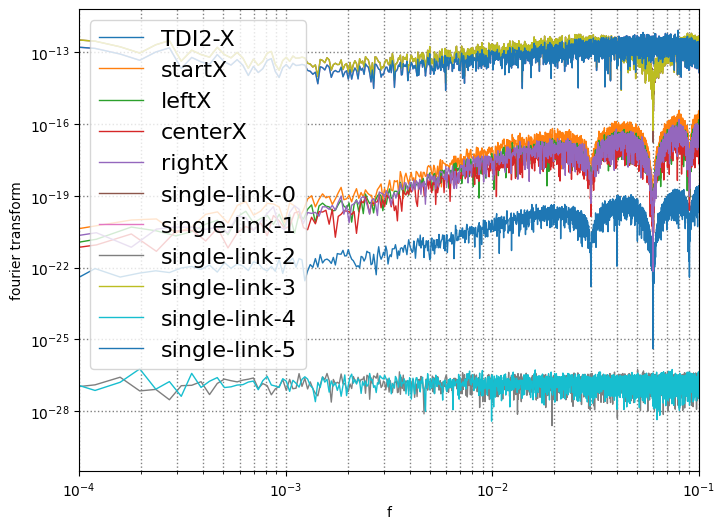

In [18]:
# View data in freq domain

import matplotlib.pyplot as plt
# Comparison with TDI variables
_, axes = plt.subplots(1, 1, figsize=(8, 6))
colors = ['blue', 'skyblue', 'red', 'orange', 'purple', 'gray']
# TDI 2.0 

iev = 10
i0=iev

ixyz=0

f,data=do_ft(XYZ_file_noise)
axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, label='TDI2-'+'XYZ'[ixyz])

for iset in range(len(XYZset)):
    f,data=do_ft(XYZset[iset])
    axes.loglog(f[i0::iev], (1+iset*0)*np.abs(data[ixyz,i0::iev]), linewidth=1, label=nameset[iset]+'XYZ'[ixyz])
    
if 0:
    f,dataL=do_ft(XYZset[1])
    f,dataR=do_ft(XYZset[3])
    data=dataR-dataL
    print(np.min(data),np.max(data),np.mean(data))
    axes.loglog(f[i0::iev], (1+iset*0)*np.abs(data[ixyz,i0::iev]), linewidth=1, label='R-L-diff-'+'XYZ'[ixyz])
            

for iy in range(6):
    f,data=do_ft(y_n)
    axes.loglog(f[i0::iev], (1+iset*0)*np.abs(data[iy,i0::iev]), linewidth=1, label="single-link-"+str(iy))
    

axes.set_xlabel("f")
axes.set_ylabel(r"fourier transform")
plt.legend(loc='upper left', fontsize=16)
# axes.set_ylim([1e-24, 1e-17])
axes.set_xlim([1e-4, 0.1])
#plt.title("PCI 2.0 (" + str(int(ns/fs/3600))+" hours, nh = "+str(nhalf)+")")
plt.grid(linewidth=1.0, 
         color='gray', 
         linestyle='dotted', 
         which='both', 
         axis='both')
#plt.show()
!free

[   343.75  57943.75  86743.75 115543.75]
691200 691451
t0,dt: 250.0 0.25
t0,dt: 312.25 0.25
t0,dt: 312.25 0.25
t0,dt: 312.25 0.25
t0,dt: 312.25 0.25
t0,dt: 250.0 0.25
              total        used        free      shared  buff/cache   available
Mem:       15911324     1695220    11930600        1280     2285504    13900016
Swap:             0           0           0


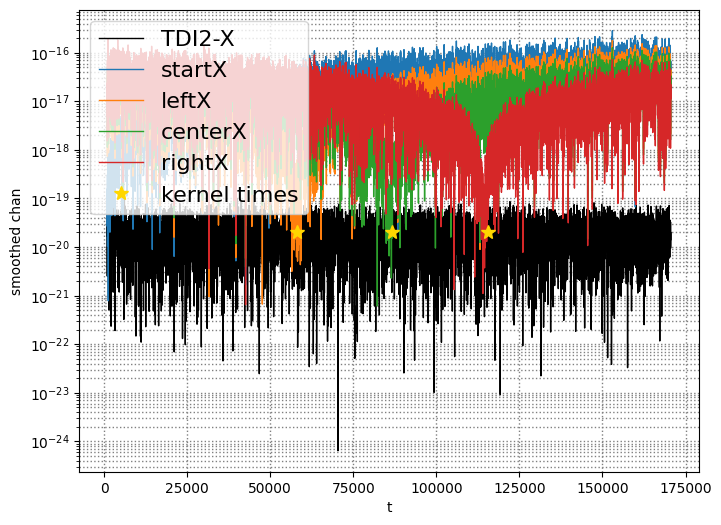

In [19]:
import scipy
# View data in decimated in the time domain

import matplotlib.pyplot as plt
# Comparison with TDI variables
_, axes = plt.subplots(1, 1, figsize=(8, 6))
colors = ['blue', 'skyblue', 'red', 'orange', 'purple', 'gray']
# TDI 2.0 

idec = 100
iev=10

ixyz=0
iskip=249

#eps=(iskip+np.arange(XYZset[0].n_samples()))/fs

print(t0set)
print(ns,XYZset[0].n_samples())

do_dec=lambda x:scipy.signal.decimate(x,q=iev)[ibuff:-ibuff]
#epsd=do_dec(eps[:])

#print(eps.shape,TDItest_n.data[ixyz][249:].shape)
data=do_dec(TDItest_n.data[ixyz][iskip:])
times=do_dec(get_times(TDItest_n)[iskip:])
axes.semilogy(times[::iev], np.abs(data[::iev]), c='k', linewidth=1, label='TDI2-'+'XYZ'[ixyz])

for iset in range(len(XYZset)):
    data=do_dec(XYZset[iset].data[ixyz])
    times=do_dec(get_times(XYZset[iset]))
    axes.semilogy(times[::iev], np.abs(data[::iev]), linewidth=1, label=nameset[iset]+'XYZ'[ixyz])

if 1:
    idxs=[int(get_index_at_time(TDItest_n,t)) for t in t0set[1:4]]
    axes.plot(get_times(TDItest_n)[idxs],[2e-20]*3,'*',markersize=10,c='gold',label='kernel times')
                
    
if 0:
    f,dataL=do_ft(XYZset[1])
    f,dataR=do_ft(XYZset[3])
    data=dataR-dataL
    print(np.min(data),np.max(data),np.mean(data))
    axes.loglog(f[i0::iev], (1+iset*0)*np.abs(data[ixyz,i0::iev]), linewidth=1, label='R-L-diff-'+'XYZ'[ixyz])
            

#for iy in range(6):
#    f,data=do_ft(y_n)
#    axes.loglog(f[i0::iev], (1+iset*0)*np.abs(data[iy,i0::iev]), linewidth=1, label="single-link-"+str(iy))
    

axes.set_xlabel(r"t")
axes.set_ylabel(r"smoothed chan")
plt.legend(loc='upper left', fontsize=16)
# axes.set_ylim([1e-24, 1e-17])
#axes.set_xlim([1e-4, 0.1])
#plt.title("PCI 2.0 (" + str(int(ns/fs/3600))+" hours, nh = "+str(nhalf)+")")
plt.grid(linewidth=1.0, 
         color='gray', 
         linestyle='dotted', 
         which='both', 
         axis='both')
#plt.show()
!free

## 2-point linearly interpolated TDI
Note that, in generating the above XYZ calculation we needed the following specialized bits:
 1. We computed the TDI filter with tdifilt=TDIFilter(data_noise,eval_time=...) at a particular points in the data stream
 2. We applied the filter to a time-data stream with tdifilt.apply_filter to get filtered XYZ time-data streams
 3. The quality of the laser noise_suppression is only good with these constant kernels for a very narrow time
 
The plan for a generalized version of this is:
 1. specify a pair of kernel eval times
 2. Construct TDIFilter for each of those
 3. Apply filter (as above) to the data for filtering with each of those filters
 4. Add the resulting time-streams, weighted by sample time for a linear interpolant
 
 
 

In [20]:
TDIFilter=pcipy.tdi_filter.DeducedTDIFilter

def linear_interp_data(channel_sets,kernel_times):
    #This function produces an output channel set from two input time-domain channel sets by linear interpolation
    #Each of the two input channels is treated as corresponding to a specific kernel_time and the
    #output should match that channel at that time.  At other times, the output is a linar interpolant
    #The output times are the same as channel set times
    times = get_times(channel_sets[0])
    eps = (times-kernel_times[0])/(kernel_times[1]-kernel_times[0])
    return TimeData(channel_sets[0].data*(1-eps) + channel_sets[1].data*eps, channel_sets[0].dt, channel_sets[0].t0, channel_sets[0].names)


#XYZ_center = TDIfilt_center.apply_filter(ytest,method='convolve')


nsnew=XYZset[0].n_samples()
ioff=125
skip=ibuff

#eps = np.array([ (ioff-skip+i-istep)/istep for i in range(nsnew)])
#eps = (get_times(XYZset[0])-t0set[1])/(t0set[3]-t0set[1])
#XYZlin =  TimeData(XYZset[1].data*(1-eps) + XYZset[3].data*eps, XYZset[0].dt, XYZset[0].t0, XYZset[0].names)
XYZlin = linear_interp_data(XYZset[1:4:2],t0set[1:4:2])
XYZlin_pk = linear_interp_data(XYZset[1:4:2],t0set[1:4:2]+1000)
XYZlin_mk = linear_interp_data(XYZset[1:4:2],t0set[1:4:2]-1000)
XYZlin_pc = linear_interp_data(XYZset[1:4:2],t0set[1:4:2]+100)
XYZlin_mc = linear_interp_data(XYZset[1:4:2],t0set[1:4:2]-100)


print(XYZlin.data.shape,XYZset[0].data.shape)



t0,dt: 312.25 0.25
t0,dt: 312.25 0.25
t0,dt: 312.25 0.25
t0,dt: 312.25 0.25
t0,dt: 312.25 0.25
(3, 691451) (3, 691451)


[   343.75  57943.75  86743.75 115543.75]
691200 691451
t0,dt: 250.0 0.25
t0,dt: 312.25 0.25
              total        used        free      shared  buff/cache   available
Mem:       15911324     1796580    11829236        1280     2285508    13798656
Swap:             0           0           0


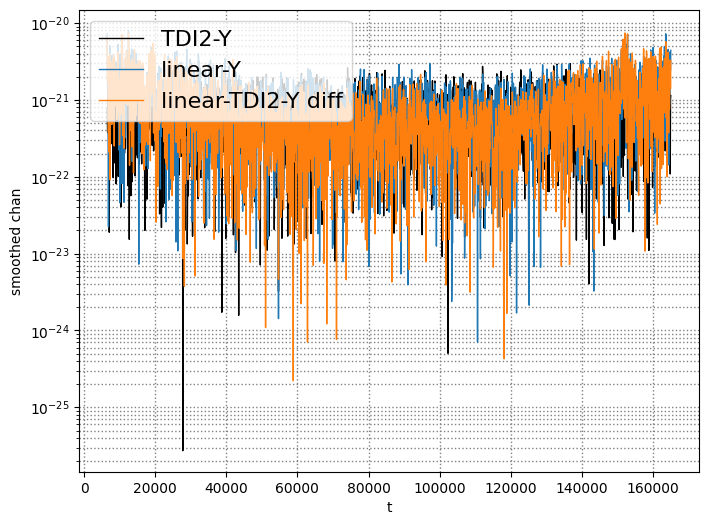

In [21]:
import scipy
# View data in decimated in the time domain

import matplotlib.pyplot as plt
# Comparison with TDI variables
_, axes = plt.subplots(1, 1, figsize=(8, 6))
colors = ['blue', 'skyblue', 'red', 'orange', 'purple', 'gray']
# TDI 2.0 

idec = 100
iev=3

ixyz=1
iskip=249

#eps=(iskip+np.arange(XYZset[0].n_samples()))/fs

print(t0set)
print(ns,XYZset[0].n_samples())

do_dec=lambda x:scipy.signal.decimate(x,q=idec)[ibuff:-ibuff]
#epsd=do_dec(eps[:])

#print(eps.shape,TDItest_n.data[ixyz][249:].shape)
data=do_dec(TDItest_n.data[ixyz][iskip:])
times=do_dec(get_times(TDItest_n)[iskip:])
refdata=data
axes.semilogy(times[::iev], np.abs(data[::iev]), c='k', linewidth=1, label='TDI2-'+'XYZ'[ixyz])

for iset in range(len(XYZset[:0])):
    data=do_dec(XYZset[iset].data[ixyz])
    times=do_dec(get_times(XYZset[iset]))
    axes.semilogy(times[::iev], np.abs(data[::iev]), linewidth=1, label=nameset[iset]+'XYZ'[ixyz])

if 0:
    idxs=[int(get_index_at_time(TDItest_n,t)) for t in t0set[1:4]]
    axes.plot(get_times(TDItest_n)[idxs],[2e-20]*3,'*',markersize=10,c='gold',label='kernel times')
                
data=do_dec(XYZlin.data[ixyz])
times=do_dec(get_times(XYZlin))
axes.semilogy(times[::iev], np.abs(data[::iev]), linewidth=1, label='linear-'+'XYZ'[ixyz])


if 1: #difference
        data=data-refdata
        axes.semilogy(times[::iev], np.abs(data[::iev]), linewidth=1, label='linear-TDI2-'+'XYZ'[ixyz]+' diff')

if 0: #interpolation with kernel times off by 1000 s
    data=do_dec(XYZlin_pk.data[ixyz])
    times=do_dec(get_times(XYZlin))
    axes.semilogy(times[::iev], np.abs(data[::iev]), linewidth=1, label='lin+1ks-'+'XYZ'[ixyz])

    data=do_dec(XYZlin_mk.data[ixyz])
    times=do_dec(get_times(XYZlin))
    axes.semilogy(times[::iev], np.abs(data[::iev]), linewidth=1, label='lin-1ks-'+'XYZ'[ixyz])

if 0:  #interpolation with kernel times off by 100 s
    data=do_dec(XYZlin_pc.data[ixyz])
    times=do_dec(get_times(XYZlin))
    axes.semilogy(times[::iev], np.abs(data[::iev]), linewidth=1, label='lin+100s-'+'XYZ'[ixyz])
    
    data=do_dec(XYZlin_mc.data[ixyz])
    times=do_dec(get_times(XYZlin))
    axes.semilogy(times[::iev], np.abs(data[::iev]), linewidth=1, label='lin-100s-'+'XYZ'[ixyz])


axes.set_xlabel(r"t")
axes.set_ylabel(r"smoothed chan")
plt.legend(loc='upper left', fontsize=16)
# axes.set_ylim([1e-24, 1e-17])
#axes.set_xlim([1e-4, 0.1])
#plt.title("PCI 2.0 (" + str(int(ns/fs/3600))+" hours, nh = "+str(nhalf)+")")
plt.grid(linewidth=1.0, 
         color='gray', 
         linestyle='dotted', 
         which='both', 
         axis='both')
#plt.show()
!free

[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]


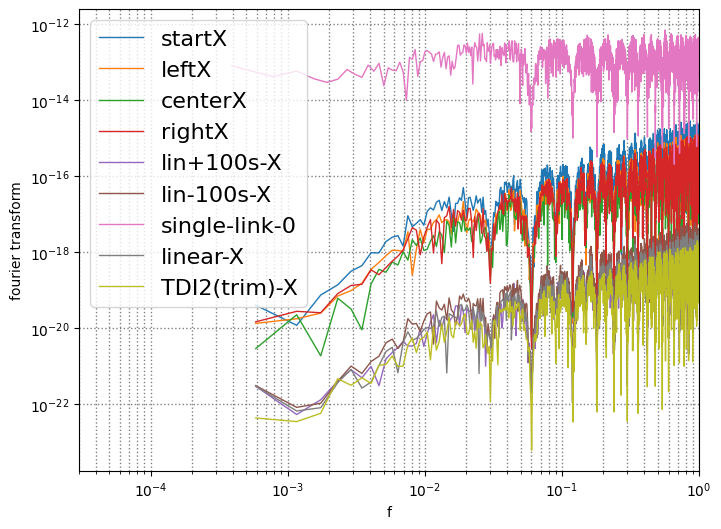

In [22]:
# View data in freq domain

import matplotlib.pyplot as plt
# Comparison with TDI variables
_, axes = plt.subplots(1, 1, figsize=(8, 6))
colors = ['blue', 'skyblue', 'red', 'orange', 'purple', 'gray']
# TDI 2.0 

iev = 100
i0=iev

ixyz=0

#f,data=do_ft(XYZ_file_noise)
#axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, label='TDI2-'+'XYZ'[ixyz])

for iset in range(len(XYZset)):
    f,data=do_ft(XYZset[iset])
    axes.loglog(f[i0::iev], (1+iset*0)*np.abs(data[ixyz,i0::iev]), linewidth=1, label=nameset[iset]+'XYZ'[ixyz])
               


if 0:
    f,data=do_ft(XYZlin_pk)
    axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, label='lin+1ks-'+'XYZ'[ixyz])
    f,data=do_ft(XYZlin_mk)
    axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, label='lin-1ks-'+'XYZ'[ixyz])

if 1:
    f,data=do_ft(XYZlin_pc)
    axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, label='lin+100s-'+'XYZ'[ixyz])
    f,data=do_ft(XYZlin_mc)
    axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, label='lin-100s-'+'XYZ'[ixyz])
        
for iy in range(1):
    f,data=do_ft(y_n)
    axes.loglog(f[i0::iev], (1+iset*0)*np.abs(data[iy,i0::iev]), linewidth=1, label="single-link-"+str(iy))

f,data=do_ft(XYZlin)
axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, label='linear-'+'XYZ'[ixyz])

f,data=do_ft(TDItest_n)
axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, label='TDI2(trim)-'+'XYZ'[ixyz])




axes.set_xlabel("f")
axes.set_ylabel(r"fourier transform")
plt.legend(loc='upper left', fontsize=16)
# axes.set_ylim([1e-24, 1e-17])
axes.set_xlim([.3e-4, 1])
#plt.title("PCI 2.0 (" + str(int(ns/fs/3600))+" hours, nh = "+str(nhalf)+")")
plt.grid(linewidth=1.0, 
         color='gray', 
         linestyle='dotted', 
         which='both', 
         axis='both')
#plt.show()

#### Comments
In the plots above (6hr data test with 2025-04-07-keplerian data) we see that the linear interpolation is effective in basically matching the pytdi result, an about a factor of 100 better than the fixed centered kernel.

Even shifting the kernel time assignments by 100s leads to something like a factor of 2 degradation in the result.  Previously, using the "t_eval_set" the error was asymmetric for a forward vs reverse shift suggesting that our nominal time alignment was not quite optimal. We shifted to reference times in the center of the
kernel evaluation span for a better fit.

Reflecting on this, we realize that our approach to the reverse engineering of the kernel is based on the assumption that the kernel is constant over the duration of its width, which is about 1 min.  Our kernel is
the coupling of a range of points in the out-channel to a single input point, while we apply the kernel as
the range of input couplings for a single output time. 

### kernel inner product
The difference in channel outcomes relate to the difference in optimal kernels as they change over time.  Can we measure the kernel difference to estimate the rate of change in some direct way?

There are many ways to define and realize an inner product which characterizes the similarity or difference of two filter kernels.  To discuss this, let us specify that and output that the value of sample $i$ of channel $k$ is given by:

$$
z_k^i =  \sum_{\alpha}^{n_{ic}}\sum_{j}^{n_{s}}S_{\alpha k}^j y_{\alpha}^{i-j}
$$

where $y_\alpha^i$ is the $i$-th sample of input channel $\alpha$ and $S_{\alpha k}^j$ are the kernel coefficients.

For independent white noise inputs, $E\left[y_{\alpha}^{i}y_{\beta}^{j}\right]=\delta_{\alpha\beta}\delta_{ij}$ the expected statistics for natural inner product of two channel $\kappa$ and $\lambda$ is then

$$
\begin{align}
E\left[\sum_i^nz_\kappa^iz_\lambda^i\right]&=\sum_i^n\sum_{\alpha}^{n_{ic}}\sum_{l}^{n_{s}}\sum_{\beta}^{n_{ic}}\sum_{m}^{n_{s}}S_{\alpha \kappa}^l S_{\beta \lambda}^m E\left[y_{\alpha}^{i-l}y_{\beta}^{i-m}\right]\\
&=n\sum_{\alpha}^{n_{ic}}\sum_{l}^{n_{s}}S_{\alpha \kappa}^l S_{\alpha \lambda}^{l} 
\end{align}
$$

A natural inner product for the kernel (i.e. the channel definition) itself could then be written:

$$
\left(\mathbf{S}_\kappa,\mathbf{S}_\lambda\right)=\sum_{\alpha}^{n_{ic}}\sum_{l}^{n_{s}}S_{\alpha \kappa}^l S_{\alpha \lambda}^{l}
$$

Generalizations of this can be written for colored and correlated noise inner products weighted in the Fourier domain.

$$
\begin{align}
\left(\mathbf{S}_\kappa,\mathbf{S}_\lambda\right)&=\sum_{k}\left(\tilde z_\kappa^k\right)^*\tilde z_\lambda^j\\
&=\sum_{\alpha}^{n_{ic}}\sum_{\beta}^{n_{ic}}\sum_{k}^{n_{s}}\left(\tilde S_{\alpha \kappa}^l\right)^* \tilde S_{\alpha \lambda}^{l}\Sigma^k_{\alpha\beta} 
\end{align}
$$

Here $\Sigma^k_{\alpha\beta}$ is the cross spectral density of the input channels.  We also note that the Fourier transforms of the kernels are assumed to be computed with zero padding on a grid of the same length as the channel.  We could motivate a different choice of inner product for each assumption about the cross spectral density.

In [23]:
def simplest_kernel_inner_product(kernel1,kernel2):
    #See note above
    pass

### Piecewise linear interpolation

In [24]:
def piecewise_linear_interp_data(channel_sets,kernel_times):
    times = get_times(channel_sets[0])
    eps = (times-kernel_times[0])/(kernel_times[1]-kernel_times[0])
    return TimeData(channel_sets[0].data*(1-eps) + channel_sets[1].data*eps, channel_sets[0].dt, channel_sets[0].t0, channel_sets[0].names)



## Sensitivity estimates

In [25]:
from scipy import signal

# Some options and prep for the welch_matrix calc
nperseg = 200000
welch_kwargs = {"fs": fs,
          "window": 'blackman',
          "nperseg": nperseg,
          "detrend": 'constant',
          "return_onesided": True,
          "scaling": 'density'}
welch_kwargs['detrend']=None

def compute_welch_matrix(ydata, **kwargs):
    """
    Compute the welch estimated PSDs and CSDs of a multivariate time series.

    Parameters
    ----------
    ydata : ndarray
        array of time series, size n_samples x n_channels
    """

    fy, _ = signal.welch(ydata[:, 0], **kwargs)
    welch_mat = np.zeros((fy.shape[0], ydata.shape[1], ydata.shape[1]), dtype=np.complex128)

    for i in range(ydata.shape[1]):
        _, welch_mat[:, i, i] = signal.welch(ydata[:, i], **kwargs)

        for j in range(i+1, ydata.shape[1]):
            _, welch_mat[:, i, j] = signal.csd(ydata[:, i], ydata[:, j], **kwargs)
            welch_mat[:, j, i] = np.conjugate(welch_mat[:, i, j])

    return fy, welch_mat

def compute_welch_matrix_td(y_td, **kwargs):
    """
    Compute the welch estimated PSDs and CSDs of a multivariate time series.

    Parameters
    ----------
    ydata : ndarray
        array of time series, size n_samples x n_channels
    """

    args=kwargs.copy()
    args['fs']=1/y_td.dt
    
    ydata=y_td.data.T
    
    fy, _ = signal.welch(ydata[:, 0], **kwargs)
    welch_mat = np.zeros((fy.shape[0], ydata.shape[1], ydata.shape[1]), dtype=np.complex128)

    for i in range(ydata.shape[1]):
        _, welch_mat[:, i, i] = signal.welch(ydata[:, i], **kwargs)

        for j in range(i+1, ydata.shape[1]):
            _, welch_mat[:, i, j] = signal.csd(ydata[:, i], ydata[:, j], **kwargs)
            welch_mat[:, j, i] = np.conjugate(welch_mat[:, i, j])

    return fy, welch_mat

def multiple_dot(a_mat, b_mat):
    """
    Perform the matrix multiplication of two list of matrices.

    Parameters
    ----------
    a : ndarray
        series of m x n matrices (array of size p x m x n)
    b : ndarray
        series of n x k matrices (array of size p x n x k)

    Returns
    -------
    c : ndarray
        array of size p x m x k containg the dot products of all matrices
        contained in a and b.


    """

    return np.einsum("ijk, ikl -> ijl", a_mat, b_mat)

def estimate_sensitivity(filt, data_n, data_gw, joint=True, welch_kwargs=welch_kwargs, strainPSD=1):
    #Sensitivity is estimated by explicit computation of the ratio of the channel noise and channel simulated GW signal
    #To scale the sensitivity, we need to know the incident strain PSD value (assumed constant here)
    #We understand this as the sum of the plus and cross PSDs for each point source in the simulation
    
    
    if filt is not None:    
        e_n = filt.apply_filter(data_n,method='convolve')    
        e_gw = filt.apply_filter(data_gw,method='convolve')
    else:
        e_n = data_n
        e_gw = data_gw
        
    n_channels=e_n.n_channels()
    print(n_channels,'channels')
    
    # Welch spectrum matrix for PCI variables from noise
    freqs, e_n_mat = compute_welch_matrix_td(e_n, **welch_kwargs)

    # Welch spectrum matrix for PCI variables from noise
    freqs, e_gw_mat = compute_welch_matrix_td(e_gw, **welch_kwargs)

    # Orthogonalization
    _, s, vh = np.linalg.svd(e_n_mat)

    # Apply the orthogonal transformation to the GW signal    
    e_gw_mat_ortho = multiple_dot(vh, multiple_dot(e_gw_mat, np.swapaxes(vh, 1, 2).conj()))

    # Apply the orthogonal transformation to the noise covariance
    e_n_mat_ortho = multiple_dot(vh, multiple_dot(e_n_mat, np.swapaxes(vh, 1, 2).conj()))
    
    factor=strainPSD

    # Output sensitivity for each variable, size nfreqs x n_channels
    # pci_sens = np.array([np.abs(s[:, j] / e_pci_gw_mat_ortho[:, j, j]) for j in range(n_channels)]).T
    sens = np.array([np.abs(e_n_mat_ortho[:, j, j] / e_gw_mat_ortho[:, j, j] * factor) for j in range(n_channels)]).T
    
    if joint:
        print('joining')
        sens = 1 / np.sum(1/np.array(sens), axis=1)
    
    return freqs, sens



In [26]:
XYZsetGW = [ filt.apply_filter(y_gw,method='convolve') for filt in TDIfiltset ]

#ioff=125*0
#eps = np.array([ (ioff-skip+i-istep)/istep for i in range(nsnew)])
#print(eps[skip:skip+ns])
#eps=0.5
#XYZlinGW =  TimeData(XYZset[0].data*(1-eps) + XYZset[1].data*eps, XYZset[0].dt, XYZset[0].t0, XYZset[0].names)
XYZlinGW = linear_interp_data(XYZsetGW[1:4:2],t0set[1:4:2])
#print(XYZlin.data.shape,XYZ.data.shape)


#XYZsetGW_ftt = [ [ fft( wd * XYZsetGW[j].data[i][skip:skip+ns]/fac ) * np.sqrt(2/(fs*k2)) for i in range(3)] for j in range(2) ]
#XYZsetGW_ftt = [ fft( wd * XYZlinGW.data[i][skip:skip+ns]/fac ) * np.sqrt(2/(fs*k2)) for i in range(3)]
f,XYZlinGW_ftt=do_ft(XYZlinGW)

#XYZleftx_fft=fft(wd * XYZset[0].data[0][skip:skip+ns]/fac ) * np.sqrt(2/(fs*k2))
#XYZrightx_fft=fft(wd * XYZset[1].data[0][skip:skip+ns]/fac ) * np.sqrt(2/(fs*k2))


0 249 0 (3, 250, 6) (6, 1035800)
1 249 0 (3, 250, 6) (6, 1035800)
2 249 0 (3, 250, 6) (6, 1035800)
0 249 0 (3, 250, 6) (6, 1035800)
1 249 0 (3, 250, 6) (6, 1035800)
2 249 0 (3, 250, 6) (6, 1035800)
0 249 0 (3, 250, 6) (6, 1035800)
1 249 0 (3, 250, 6) (6, 1035800)
2 249 0 (3, 250, 6) (6, 1035800)
0 249 0 (3, 250, 6) (6, 1035800)
1 249 0 (3, 250, 6) (6, 1035800)
2 249 0 (3, 250, 6) (6, 1035800)
t0,dt: 312.25 0.25
[False  True  True ...  True  True  True]


In [27]:
# Compute welch matrix for the TDI 2.0 noise
e_tdi2_n = np.array([x2_noise[skip:skip+ns],
                     y2_noise[skip:skip+ns],
                     z2_noise[skip:skip+ns]] ).T
p_tdi2_freqs, p_tdi2_n_mat = compute_welch_matrix(e_tdi2_n, **welch_kwargs)
# Compute the welch matrix for the TDI 2.0 GW signal
e_tdi2_gw = np.array([x2_gw[skip:skip+ns],
                      y2_gw[skip:skip+ns],
                      z2_gw[skip:skip+ns]]).T
freqs, p_tdi2_gw_mat = compute_welch_matrix(e_tdi2_gw, **welch_kwargs)

# Orthogonalization
u_tdi, s_tdi, vh_tdi = np.linalg.svd(p_tdi2_n_mat)

# Apply the orthogonal transformation to the GW signal
p_tdi2_gw_mat_ortho = multiple_dot(vh_tdi, multiple_dot(p_tdi2_gw_mat, np.swapaxes(vh_tdi, 1, 2).conj()))

# Empirical orthogonalization of TDI
tdi2_sh=np.array([np.abs(p_tdi2_gw_mat_ortho[:, j_tdi, j_tdi] / np.abs(s_tdi[:, j_tdi])) for j_tdi in range(3)])
mean_tdi2_sh = 1 / np.sum(tdi2_sh, axis=0)
mean_tdi2_sens = [freqs, mean_tdi2_sh]

print(XYZset[2].data.T.shape,e_tdi2_n.shape)

(691451, 3) (691200, 3)


In [28]:
# Compute welch matrix for the TDI 2.0 noise
e_tdi2_n = np.array([x2_noise[skip:skip+ns],
                     y2_noise[skip:skip+ns],
                     z2_noise[skip:skip+ns]] ).T
tdi2_td=TimeData(e_tdi2_n.T,dt=1/fs,t0=skip/fs,names=mosas_order)

freqs, p_tdi2_n_mat = compute_welch_matrix(e_tdi2_n, **welch_kwargs)
# Compute the welch matrix for the TDI 2.0 GW signal
e_tdi2_gw = np.array([x2_gw[skip:skip+ns],
                      y2_gw[skip:skip+ns],
                      z2_gw[skip:skip+ns]]).T
freqs, p_tdi2_gw_mat = compute_welch_matrix(e_tdi2_gw, **welch_kwargs)
tdi2_gw=TimeData(e_tdi2_gw.T,dt=1/fs,t0=skip/fs,names=mosas_order)



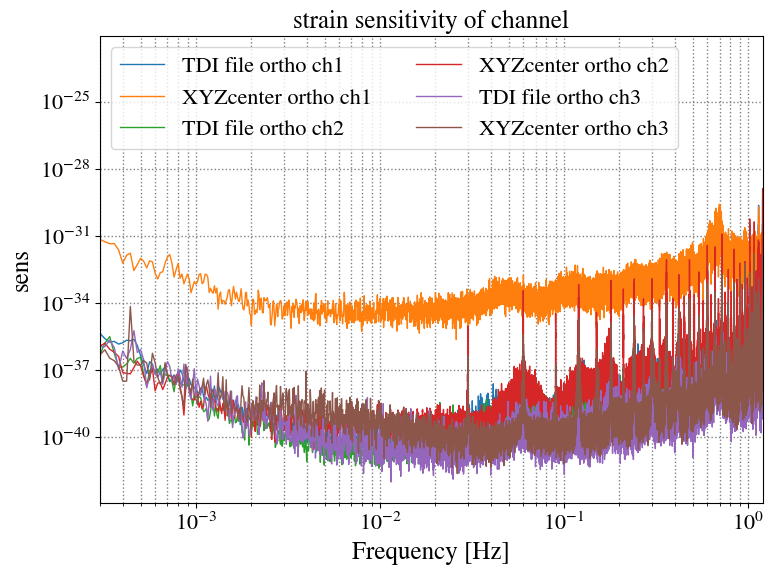

In [29]:
from pcipy import plotting 
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))



freqs, n_mat = compute_welch_matrix_td(XYZset[2], **welch_kwargs)
_, s, vh = np.linalg.svd(n_mat)
n_mat_ortho = multiple_dot(vh, multiple_dot(n_mat, np.swapaxes(vh, 1, 2).conj()))
freqs, gw_mat = compute_welch_matrix_td(XYZsetGW[2], **welch_kwargs)
gw_mat_ortho = multiple_dot(vh, multiple_dot(gw_mat, np.swapaxes(vh, 1, 2).conj()))

for ichan in range(3):
    cmpt = 'ch'+'123'[ichan]
    axes.loglog(p_tdi2_freqs, 1/tdi2_sh[ichan],
            linewidth=1, label=r'TDI file ortho '+cmpt)
    sens = 1/np.abs(gw_mat_ortho[:,ichan,ichan]/n_mat_ortho[:,ichan,ichan])
    #sens = 1/np.abs(gw_mat_ortho[:,ichan,ichan]/s[:,ichan])
    axes.loglog(freqs, sens,
                linewidth=1, label=r'XYZcenter ortho '+cmpt)

axes.legend(loc='upper left', ncol=2)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"sens")
axes.set_xlim([3e-4, 1.2])
#axes.set_ylim([3e-19, 1e-13])
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_title("strain sensitivity of channel")
plt.show()

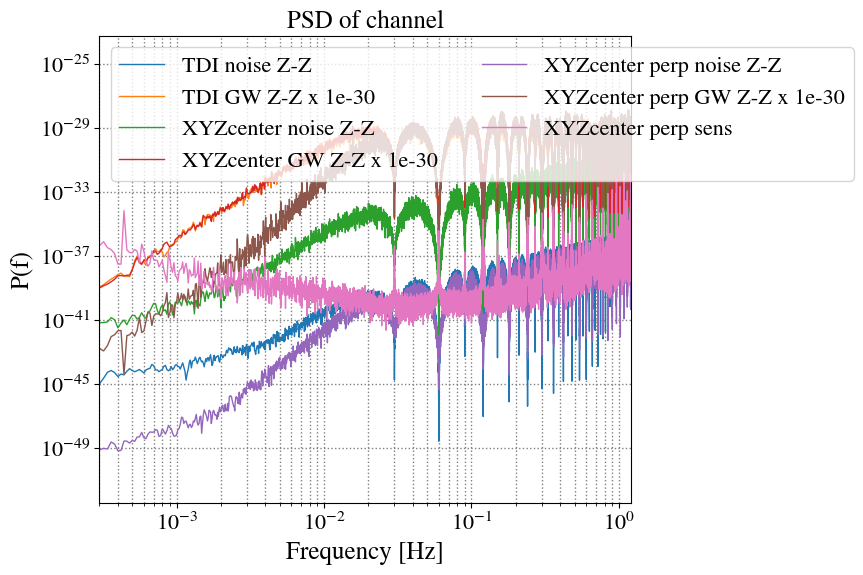

In [30]:
from pcipy import plotting 
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
iplot=2
jplot=2

fac=1e-30

cmpt = 'XYZ'[iplot]+'-'+'XYZ'[jplot]
cmptG = 'XYZ'[iplot]+'-'+'XYZ'[jplot]+' x '+str(fac)
axes.loglog(freqs, np.abs(p_tdi2_n_mat[:,iplot,jplot]),
            linewidth=1, label=r'TDI noise '+cmpt)
axes.loglog(freqs, np.abs(p_tdi2_gw_mat[:,iplot,jplot])*fac,
            linewidth=1, label=r'TDI GW '+cmptG)
if 0:
    x=[np.linalg.det(m) for m in p_tdi2_n_mat]
    axes.loglog(freqs, x,
            linewidth=1, label=r'TDI det')

if 1:
    freqs, n_mat = compute_welch_matrix_td(XYZset[2], **welch_kwargs)
    axes.loglog(freqs, np.abs(n_mat[:,iplot,jplot]),
                linewidth=1, label=r'XYZcenter noise '+cmpt)
    freqs, gw_mat = compute_welch_matrix_td(XYZsetGW[2], **welch_kwargs)
    axes.loglog(freqs, np.abs(gw_mat[:,iplot,jplot])*fac,
                linewidth=1, label=r'XYZcenter GW '+cmptG)
    if 0:
        x=[np.linalg.det(m) for m in n_mat]
        axes.loglog(freqs, x,
            linewidth=1, label=r'TDI det')
    
    if 1:
        _, s, vh = np.linalg.svd(n_mat)
        n_mat_ortho = multiple_dot(vh, multiple_dot(n_mat, np.swapaxes(vh, 1, 2).conj()))
        axes.loglog(freqs, np.abs(n_mat_ortho[:,iplot,jplot]),
                    linewidth=1, label=r'XYZcenter perp noise '+cmpt)
        gw_mat_ortho = multiple_dot(vh, multiple_dot(gw_mat, np.swapaxes(vh, 1, 2).conj()))
        axes.loglog(freqs, np.abs(gw_mat_ortho[:,iplot,jplot])*fac,
                    linewidth=1, label=r'XYZcenter perp GW '+cmptG)
        if 1:
            sens = 1/np.abs(gw_mat_ortho[:,iplot,jplot]/n_mat_ortho[:,iplot,jplot])
            axes.loglog(freqs, sens,
                    linewidth=1, label=r'XYZcenter perp sens ')
        if 0:
            x=[np.linalg.det(m) for m in n_mat_ortho]
            axes.loglog(freqs, x,
                linewidth=1, label=r'TDI det')

axes.legend(loc='upper left', ncol=2)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"P(f)")
axes.set_xlim([3e-4, 1.2])
#axes.set_ylim([3e-19, 1e-13])
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_title("PSD of channel")
plt.show()

In [31]:
sens_list = []
sens_list += [["TDIfile", estimate_sensitivity(None,XYZ_file_noise, XYZ_file_gw, joint=True)]]
ytestn=get_range(tdi2_td,skip-125,skip+125+ns)
ytestgw=get_range(tdi2_gw,skip-125,skip+125+ns)
sens_list += [["TDIfile[ns]", estimate_sensitivity(None,ytestn,ytestgw,joint=True)]]
sens_list += [[nameset[i], estimate_sensitivity(TDIfiltset[i],ytest_n,ytest_gw,joint=True)] for i in range(2,3)]
sens_list += [["linear", estimate_sensitivity(None,XYZlin,XYZlinGW,joint=True)] ]

#TDIfiltset = [ TDIFilter(data_noise,i0=i) for i in i0set ]



3 channels
joining
(3, 691200)
(3, 691200)
3 channels
joining
0 249 0 (3, 250, 6) (6, 691700)
1 249 0 (3, 250, 6) (6, 691700)
2 249 0 (3, 250, 6) (6, 691700)
0 249 0 (3, 250, 6) (6, 691700)
1 249 0 (3, 250, 6) (6, 691700)
2 249 0 (3, 250, 6) (6, 691700)
3 channels
joining
3 channels
joining


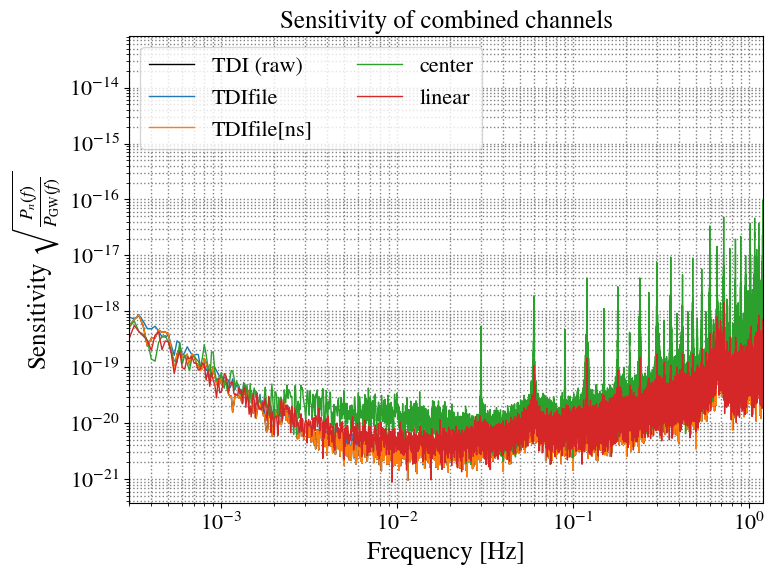

In [32]:
from pcipy import plotting 
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.loglog(mean_tdi2_sens[0], np.sqrt(mean_tdi2_sens[1]), 
            linewidth=1, label=r'TDI (raw)',
            color='black')
for j in range(len(sens_list)):
    #print(j)
    axes.loglog(sens_list[j][1][0], np.sqrt(sens_list[j][1][1]), 
                linewidth=1, label=sens_list[j][0], rasterized=True)
axes.legend(loc='upper left', ncol=2)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes.set_xlim([3e-4, 1.2])
#axes.set_ylim([3e-19, 1e-13])
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_title("Sensitivity of combined channels")
plt.show()

In [33]:
sens_list = []
sens_list += [["TDIfile", estimate_sensitivity(None,tdi2_td, tdi2_gw, joint=False)]]
ytestn=get_range(tdi2_td,skip-125,skip+125+ns)
ytestgw=get_range(tdi2_gw,skip-125,skip+125+ns)
sens_list += [["TDIfile[ns]", estimate_sensitivity(None,ytest_n,ytest_gw,joint=False)]]
#ytestn=get_range(y_td,skip-125,skip+125+ns)
#ytestgw=get_range(y_gw,skip-125,skip+125+ns)
sens_list += [["center", estimate_sensitivity(TDIfilt_center,ytestn,ytestgw,joint=False)]]
sens_list += [[["left","right"][i], estimate_sensitivity(TDIfiltset[i],ytestn,ytestgw,joint=False)] for i in range(2)]
print(sens_list)

3 channels
(3, 691200)
(3, 691200)
6 channels


NameError: name 'TDIfilt_center' is not defined

In [ ]:
from pcipy import plotting 
for ix in range(3):
    plotting.plotconfig(lbsize=18, lgsize=16)
    _, axes = plt.subplots(1, 1, figsize=(8, 6))

    axes.loglog(mean_tdi2_sens[0], np.sqrt(1/tdi2_sh[ix]), 
                linewidth=1, label=r'TDI (raw)',
                color='black')
    for j in range(len(sens_list)):
        #print(j)
        axes.loglog(sens_list[j][1][0], np.sqrt(sens_list[j][1][1][:,ix]), 
                    linewidth=1, label=sens_list[j][0], rasterized=True)
    axes.legend(loc='upper left', ncol=2)
    axes.set_xlabel("Frequency [Hz]")
    axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
    axes.set_xlim([1e-3, 1.2])
    #axes.set_ylim([3e-19, 1e-13])
    axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
    axes.set_title("Sensitivity of "+'XYZ'[ix]+" channel")
    plt.show()

In [ ]:
help(white_generator)

In [ ]:
help(StochasticPointSource)

In [ ]:
x2_fft.shape

In [ ]:
help(TimeData)

In [ ]:
display(TimeData.__dict__)

In [ ]:
ns

In [ ]:
tdi2_td.data.shape

In [ ]:
XYZset